# Diagnostics of simulation results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.colors import LogNorm
import Utilitis_HybridCode as utils


# ... import simulation data
#data = np.loadtxt('Results/01_WavenumberScan/simulation_data_T=400_k=2.0.txt')
#data = np.loadtxt('Results/simulation_data_T=100_L=2pi_newCode.txt')
data = np.loadtxt('Results/03_DipoleField/simulation_data_T=3000_L=327.7_xi=8.62e-5.txt')
# ...

In [14]:
# ... get simulation parameters
pa = data[0]

eps0  = pa[0]
mu0   = pa[1]
c     = pa[2]
qe    = pa[3]
me    = pa[4]
B0z   = pa[5]
wce   = pa[6]
wpe   = pa[7]
nuh   = pa[8]
nh    = pa[9]
wpar  = pa[10]
wperp = pa[11]
k     = pa[12]
ini   = np.int(pa[13])
amp   = pa[14]
eps   = pa[15]
Lz    = pa[16]
Nz    = np.int(pa[17])
T     = pa[18]
dt    = pa[19]
p     = np.int(pa[20])
Lv    = pa[21]
Nv    = np.int(pa[22])
Np    = np.int(pa[23])
xi    = pa[24]
Ld    = pa[25]

bcs_p = pa[26]
bcs_f = pa[27]
bcs_d = pa[28]
bcs_g = pa[29]
# ...

In [30]:
Np

500000

"\nplt.subplot(223)\nplt.contourf(Time,Omega,Sxx,100,cmap = 'jet')\n#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')\n\nplt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')\nplt.xlabel('t |wce|')\nplt.xlabel('w / |wce|')\nplt.ylim((0,2))\nplt.colorbar()\nplt.title('time-frequency spectrogram')\n"

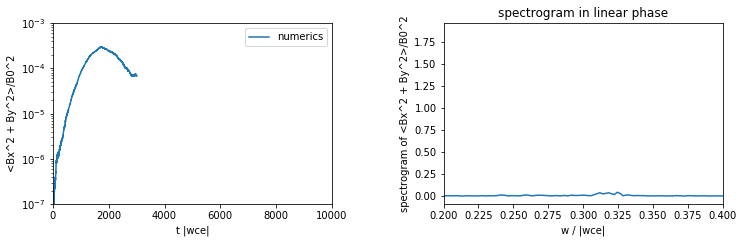

In [17]:
# ... additional parameters 
if bcs_f == 1:
    Nb = Nz
elif bcs_f == 2:
    Nb = Nz + p - 2
s = 6
# ...



# ... discretization parameters
dz = Lz/Nz
zj = np.linspace(0, Lz, Nz + 1)

Nt = np.int(T/dt)
tn = np.linspace(0, T, Nt + 1)
# ...




# ... get simulation data

if bcs_f == 1:

    uj = data[1:, 0:s*Nb]
    yhj = data[1:, s*Nb:8*Nb]

    ejx  = uj[:, 0::6]
    ejy  = uj[:, 1::6]
    bjx  = uj[:, 2::6]
    bjy  = uj[:, 3::6]
    ycjx = uj[:, 4::6]
    ycjy = uj[:, 5::6]
    yhjx = yhj[:, 0::2]
    yhjy = yhj[:, 1::2]

elif bcs_f == 2:

    uj = data[1:, 0:s*Nb]
    yhj = data[1:, s*Nb:8*Nb]

    ejx = np.c_[np.zeros(Nt + 1), uj[:, 0::6], np.zeros(Nt + 1)]
    ejy = np.c_[np.zeros(Nt + 1), uj[:, 1::6], np.zeros(Nt + 1)]
    bjx = np.c_[np.zeros(Nt + 1), uj[:, 2::6], np.zeros(Nt + 1)]
    bjy = np.c_[np.zeros(Nt + 1), uj[:, 3::6], np.zeros(Nt + 1)]
    
    ycjx = np.c_[np.zeros(Nt + 1), uj[:, 4::6], np.zeros(Nt + 1)]
    ycjy = np.c_[np.zeros(Nt + 1), uj[:, 5::6], np.zeros(Nt + 1)]
    yhjx = yhj[:, 0::2]
    yhjy = yhj[:, 1::2]
# ...



def damp(z):
    return 0*z

def B0(z):
    return 0*z


# ... create B-spline basis and compute mass matrix
basis,N,quad_points,weights = utils.createBasis(Lz,Nz,p,bcs_f)
M = utils.matrixAssembly(basis,weights,quad_points,B0,bcs_f)[0]
# ...




# ... solve the dispersion relation for a fixed k to get ocillation frequency and growth rate 
omega = utils.solveDispersionHybrid(k,+1,c,wce,wpe,wpar,wperp,nuh,0.5 + 0j,1e-6,100)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)
# ...





# ... compute averaged quadratic magnetic field
mean_Bx2 = np.zeros(Nt+1)
mean_B2 = np.zeros(Nt+1)

for j in range(0,Nt+1):
    mean_Bx2[j] = 1/Lz*np.dot(bjx[j],np.dot(M,bjx[j]))
    mean_B2[j] = 1/Lz*(np.dot(bjx[j],np.dot(M,bjx[j])) + np.dot(bjy[j],np.dot(M,bjy[j])))
# ...

                       
                       
# ... compute fft for frequency analysis in linear phase 
Ntend = Nt
spec = np.fft.fft(mean_Bx2[0:Ntend+1])
spec = np.fft.fftshift(spec)
w = np.linspace(0,Ntend,Ntend+1) - Ntend/2
w = 2*np.pi*w/(Ntend*dt)
# ...



                       
# ... plot results
f1 = plt.figure()
f1.set_figheight(8)
f1.set_figwidth(12)
plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

plt.subplot(221)
plt.semilogy(tn,mean_B2,label = 'numerics')
t2 = np.linspace(0,T,100)
#plt.semilogy(t2,1.2e-9*np.exp(t2*gamma*2),label = 'expected growth rate')
plt.xlabel('t |wce|')
plt.ylabel('<Bx^2 + By^2>/B0^2')
plt.xlim((0,10000))
plt.ylim((1e-7,1e-3))
plt.legend()

plt.subplot(222)
plt.plot(w,np.abs(spec))
plt.xlim((0.2,0.4))
plt.xlabel('w / |wce|')
plt.ylabel('spectrogram of <Bx^2 + By^2>/B0^2')
#plt.plot(np.ones(20)*2*omega_r,np.linspace(0,4e-6,20),label = 'expected real frequency')
#plt.legend()
plt.title('spectrogram in linear phase')

'''
plt.subplot(223)
plt.contourf(Time,Omega,Sxx,100,cmap = 'jet')
#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')

plt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')
plt.xlabel('t |wce|')
plt.xlabel('w / |wce|')
plt.ylim((0,2))
plt.colorbar()
plt.title('time-frequency spectrogram')
'''
# ...

In [73]:
from Utils_Dipole.evaluation import evaluation
Bx = np.zeros(Nt+1)

for i in range(0,Nt+1):
    if i%50 == 0:
        print(i)
    Bx[i] = evaluation(bjx[i],basis,Lz/2,p,bcs_f)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150

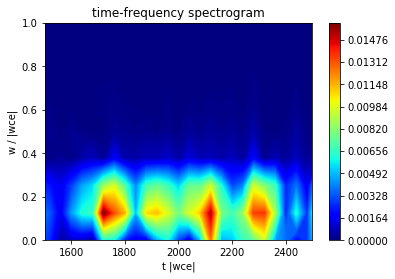

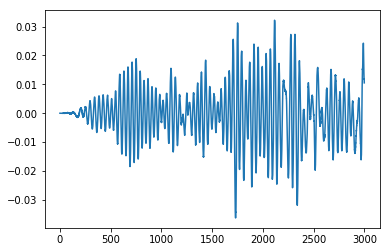

In [95]:
# ... compute time-frequency spectrum
f, t, Sxx = np.abs(signal.stft(Bx,1/dt,nperseg=500,noverlap=100,nfft=None))
om = 2*np.pi*f
lvls = np.logspace(-15,-3,200)
Time,Omega = np.meshgrid(t,om)
# .


plt.contourf(Time,Omega,Sxx,500,cmap = 'jet')
#plt.contourf(Time,Omega,Sxx,norm = LogNorm(),levels = lvls, cmap = 'jet')
#plt.contourf(Time,Omega,Sxx,norm = LogNorm(), cmap = 'jet')

#plt.plot(np.linspace(t[0],t[-1],100),np.ones(100)*omega_r*2,'k--')
plt.xlabel('t |wce|')
plt.ylabel('w / |wce|')
plt.ylim((0,1))
plt.xlim((1500,2500))
plt.colorbar()
plt.title('time-frequency spectrogram')

plt.figure()
#plt.plot(tn[10000:18000],Bx[10000:18000])
plt.plot(tn,Bx)

(0, 1)

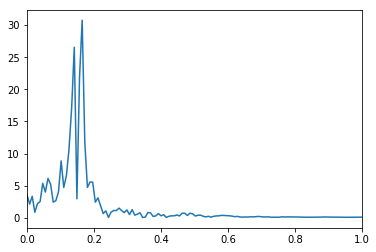

In [100]:
Nstart = 10000
Nend = 18000
Delta = Nend - Nstart
spec = np.fft.fft(Bx[Nstart:Nend+1])
spec = np.fft.fftshift(spec)
w = np.linspace(0,Delta,Delta+1) - Delta/2
w = 2*np.pi*w/(Delta*dt)
plt.plot(w,np.abs(spec))
plt.xlim((0,1))

In [101]:
from Utils_Dipole.evaluation import evaluation

# ... compute 2D fft to investigate dispersion relation
w = np.linspace(0,Nt,Nt+1) - Nt/2
w = 2*np.pi/T*w

ks = np.linspace(0,Nz,Nz+1) - Nz/2
ks = 2*np.pi/Lz*ks

Bx = np.zeros((Nt+1,Nz+1))

for i in range(0,Nt+1):
    if i%50 == 0:
        print('time steps finished: ' + str(i))
    Bx[i] = evaluation(bjx[i],basis,zj,p,bcs_f)

time steps finished: 0
time steps finished: 50
time steps finished: 100
time steps finished: 150
time steps finished: 200
time steps finished: 250
time steps finished: 300
time steps finished: 350
time steps finished: 400
time steps finished: 450
time steps finished: 500
time steps finished: 550
time steps finished: 600
time steps finished: 650
time steps finished: 700
time steps finished: 750
time steps finished: 800
time steps finished: 850
time steps finished: 900
time steps finished: 950
time steps finished: 1000
time steps finished: 1050
time steps finished: 1100
time steps finished: 1150
time steps finished: 1200
time steps finished: 1250
time steps finished: 1300
time steps finished: 1350
time steps finished: 1400
time steps finished: 1450
time steps finished: 1500
time steps finished: 1550
time steps finished: 1600
time steps finished: 1650
time steps finished: 1700
time steps finished: 1750
time steps finished: 1800
time steps finished: 1850
time steps finished: 1900
time step

time steps finished: 15600
time steps finished: 15650
time steps finished: 15700
time steps finished: 15750
time steps finished: 15800
time steps finished: 15850
time steps finished: 15900
time steps finished: 15950
time steps finished: 16000
time steps finished: 16050
time steps finished: 16100
time steps finished: 16150
time steps finished: 16200
time steps finished: 16250
time steps finished: 16300
time steps finished: 16350
time steps finished: 16400
time steps finished: 16450
time steps finished: 16500
time steps finished: 16550
time steps finished: 16600
time steps finished: 16650
time steps finished: 16700
time steps finished: 16750
time steps finished: 16800
time steps finished: 16850
time steps finished: 16900
time steps finished: 16950
time steps finished: 17000
time steps finished: 17050
time steps finished: 17100
time steps finished: 17150
time steps finished: 17200
time steps finished: 17250
time steps finished: 17300
time steps finished: 17350
time steps finished: 17400
t

In [ ]:
from matplotlib.colors import LogNorm
from Utils.dispersionSolver import solveDispersionCold

Bxkw = np.fft.fft2(Bx)
K,W = np.meshgrid(ks,w)
Bkw = np.fft.fftshift(Bxkw)
Bkw_plot = np.abs(Bkw)/np.abs(Bkw).max()
plt.pcolor(K,W,Bkw_plot,cmap = 'inferno',norm = LogNorm(vmin = Bkw_plot.min(),vmax = Bkw_plot.max()))
plt.xlim((0,6))
plt.ylim((0,5))
plt.xlabel('k')
plt.ylabel('w')

# ... Newton method for cold plasma dispersion relation for fixed k
k1 = np.linspace(0.1,6.0,40)

w1_1 = np.zeros(40)
w1_2 = np.zeros(40)
w1_3 = np.zeros(40)

w1_1[0] = 0.0001 
w1_2[0] = 1.5001 
w1_3[0] = 2.5001


for i in range(0,40):
    
    if i == 0:
        w1_1[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_1[i],1e-6,100)[0]
        w1_2[i] = solveDispersionCold(k1[i],-1,c,wce,wpe,w1_2[i],1e-6,100)[0]
        w1_3[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_3[i],1e-6,100)[0]
    
    else:
        w1_1[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_1[i-1],1e-6,100)[0]
        w1_2[i] = solveDispersionCold(k1[i],-1,c,wce,wpe,w1_2[i-1],1e-6,100)[0]
        w1_3[i] = solveDispersionCold(k1[i],+1,c,wce,wpe,w1_3[i-1],1e-6,100)[0]
    
# ...

plt.plot(k1,w1_1,'k--')
plt.plot(k1,w1_2,'k--')
plt.plot(k1,w1_3,'k--')